<a href="https://colab.research.google.com/github/haseungchung/Machine-Learning-and-Deep-Learning-Projects/blob/main/Residual%20Convolutional%20Neural%20Network%20for%20Communication%20Signal%20Classification/Residual%20Convolutional%20Neural%20Network%20for%20Communication%20Signal%20Classification_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.constraints import max_norm
from keras import regularizers, layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from keras import backend as K
from keras.layers.core import Activation
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout, Add
from keras.regularizers import *
import tensorflow.python.keras.backend as tfback #described in MRN model (resstack)
import numpy as np
import os,random
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import _pickle as cPickle
import random, sys, keras
from operator import itemgetter
from google.colab import files
# files.download("RML2016.10a.tar.bz2")

In [2]:
# !pip uninstall tensorflow
# !pip install tensorflow-gpu==2.0.0
# !pip install keras==2.3.1
# !pip install --exists-action i --upgrade keras --user

print(keras.__version__)
print(tf.__version__)
# python3.__version__
# python --version

2.8.0
2.8.0


In [3]:
'''  Cell 3
The reason for this cell is because in the time of this script 
(Keras version 2.3.1 and tf version 2.1.0), the residual stack bloc that we use
later on returns an error "AttributeError: module 'tensorflow_core._api.v2.config' 
has no attribute 'experimental_list_devices'". This is related to incompatibility
between the Keras version and tensorflow version, because tensorflow 2.1.0
deprecated experimental_list_devices. Someone has stated that doing this method
only allows for one GPU core to be allocated, not multiple. This needs an update
'''

# import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_file_from_drive(folder_id, file_name):
  file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  for file in file_list:
    if file['title'] == file_name:
      return file['id']

def upload_file_to_drive(file_name, file_data):
  uploaded = drive.CreateFile({'title': file_name})
  uploaded.SetContentString(file_data)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

drive_folder_id = '1JNJdIC-RWwosUbQJL9cjbPu_3KjurP3B'

In [5]:
def upload_data_system():
  downloaded = drive.CreateFile({'id': get_file_from_drive(drive_folder_id, 'RML2016.10a_dict.pkl')})
  downloaded.GetContentFile('RML2016.10a_dict.pkl') 

upload_data_system()

In [6]:
'''Open and organize data pickle file into data, labels'''
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(220000, 2, 128)


In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
'''Partition the data into training and test sets of the form we can train/test on 
while keeping SNR and Mod labels handy for each'''
np.random.seed(3)
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)
train_idx = (np.random.choice(range(0,n_examples), size=n_train, replace=False))
test_idx = [i for i in range(0,n_examples) if i not in train_idx]
random.shuffle(test_idx)
X_train = X[train_idx]
X_test =  X[test_idx]

Y_train_mod = [lbl[i][0] for i in train_idx] 
Y_test_mod = [lbl[i][0] for i in test_idx] 

Y_train_ind = np.zeros((len(Y_train_mod),len(mods)))
Y_test_ind = np.zeros((len(Y_test_mod),len(mods)))

# Y_train_ind = np.zeros(len(Y_train_mod))
# Y_test_ind = np.zeros((len(Y_test_mod))

In [9]:
for i in range(len(train_idx)):
  Y_train_indx=mods.index(Y_train_mod[i])
  Y_train_ind[i][Y_train_indx]=1

for i in range(len(test_idx)):
  Y_test_indx=mods.index(Y_test_mod[i])
  Y_test_ind[i][Y_test_indx]=1

print(Y_train_ind[0:10])
print(Y_test_ind[0:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [10]:
print(X_train.shape[1:])

def residual_unit(input, Filters):
    X1=Conv2D(Filters, (2,5), padding='same', data_format="channels_first", activation='relu')(input)
    X2=Conv2D(Filters, (2,5), padding='same', data_format="channels_first", activation='linear')(X1)
    X3=Add()([X2, input])
    return X3

def residual_stack(input, Filters, max_pool):
    X1=Conv2D(Filters, (1,1), padding='same', data_format="channels_first", )(input)
    X2=residual_unit(X1,Filters)
    X3=residual_unit(X2,Filters)
    output=X3
    if max_pool=='(1,2)':
        output = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='valid', data_format="channels_first")(X3)
    elif max_pool=='(2,2)':
        output = MaxPooling2D(pool_size=(2, 2), strides=(1, 2), padding='valid', data_format="channels_first")(X3)
    return output

(2, 128)


In [11]:
Xinput = Input(shape=X_train.shape[1:])
X1 = Reshape([1]+list(X_train.shape[1:]))(Xinput)
# First stack has a 2,2 max pool size
X2 = residual_stack(X1,128,max_pool='(2,2)') #Note: refer to Cell 3 for comments
# Second stack has a 1,2 max pool size
X3 = residual_stack(X2,64,max_pool='(1,2)')
# Second stack has a 1,2 max pool size
X4 = residual_stack(X3,32,max_pool='(1,2)')
# Fully connected layer
X5 = Flatten(data_format="channels_first")(X4)
X6 = Dense(256, activation='selu', kernel_initializer='he_normal')(X5)
X7 = AlphaDropout(0.3)(X6)
X8 = Dense(128, activation='selu', kernel_initializer='he_normal')(X7)
X9 = AlphaDropout(0.3)(X8)
X10 = Dense(len(mods), activation='softmax', kernel_initializer='he_normal')(X9)
Xoutput = X10
MRN = Model(Xinput, Xoutput, name='MRN')
MRN.summary()
MRN.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0005))

Model: "MRN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 128)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 2, 128)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 2, 128)  256         ['reshape[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 2, 128)  163968      ['conv2d[0][0]']                 
                                                                                                

In [12]:
history = MRN.fit(X_train, Y_train_ind, batch_size=1024, epochs=35, validation_split = 0.15)

Epoch 1/35
147/147 [==============================] - 82s 525ms/step - loss: 2.3502 - val_loss: 1.9093
Epoch 2/35
147/147 [==============================] - 76s 520ms/step - loss: 1.8403 - val_loss: 1.6629
Epoch 3/35
147/147 [==============================] - 76s 519ms/step - loss: 1.6307 - val_loss: 1.7129
Epoch 4/35
147/147 [==============================] - 76s 519ms/step - loss: 1.5234 - val_loss: 1.9134
Epoch 5/35
147/147 [==============================] - 76s 517ms/step - loss: 1.4813 - val_loss: 1.4472
Epoch 6/35
147/147 [==============================] - 76s 517ms/step - loss: 1.6485 - val_loss: 1.8030
Epoch 7/35
147/147 [==============================] - 76s 515ms/step - loss: 1.6409 - val_loss: 1.5902
Epoch 8/35
147/147 [==============================] - 76s 515ms/step - loss: 1.4053 - val_loss: 1.3873
Epoch 9/35
147/147 [==============================] - 76s 515ms/step - loss: 1.3524 - val_loss: 1.3301
Epoch 10/35
147/147 [==============================] - 76s 515ms/step - l

In [21]:
# Show simple version of performance
score = MRN.evaluate(X_test, Y_test_ind, verbose=1, batch_size=1024)
print(score)

43/43 [==============================] - 8s 185ms/step - loss: 1.2746
1.274584412574768


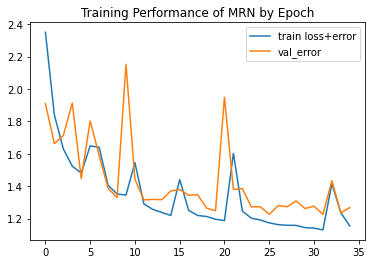

In [28]:
# Show loss curves 
plt.figure()
plt.title('Training Performance of MRN by Epoch')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

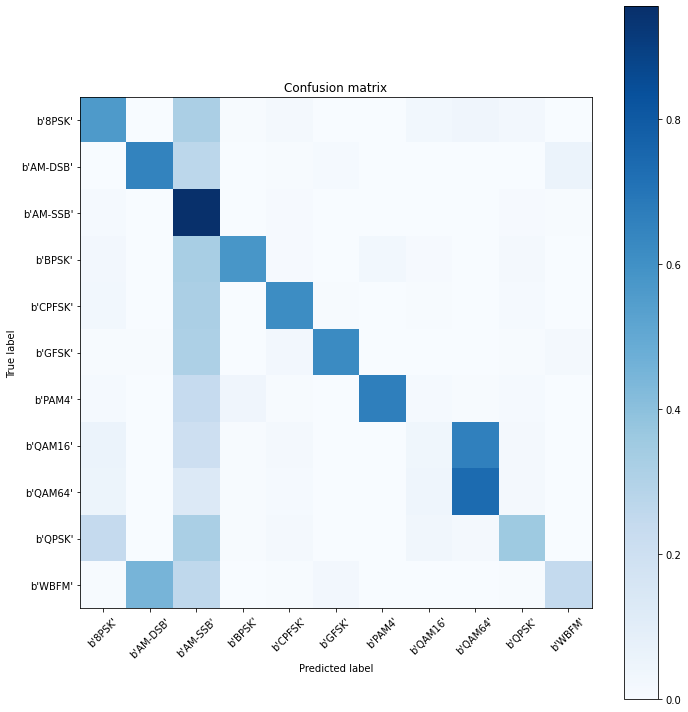

In [24]:
# Plot confusion matrix
Y_pred_test = MRN.predict(X_test)
conf = np.zeros([len(mods),len(mods)])
confnorm = np.zeros([len(mods),len(mods)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test_ind[i]).index(1)
    k = int(np.argmax(Y_pred_test[i]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(mods)):
    confnorm[i] = conf[i] / np.sum(conf[i])
plot_confusion_matrix(confnorm, labels=mods)

In [25]:
# print(list(test_SNRs))
# list(test_SNRs)

Overall Accuracy:  0.0832579185520362
Overall Accuracy:  0.09872611464968153
Overall Accuracy:  0.09847122302158273
Overall Accuracy:  0.08054919908466819
Overall Accuracy:  0.1346153846153846
Overall Accuracy:  0.2532613585245164
Overall Accuracy:  0.3448119619392841
Overall Accuracy:  0.5084901330885727
Overall Accuracy:  0.6243119266055046
Overall Accuracy:  0.690339655932951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Overall Accuracy:  0.7454056476916181
Overall Accuracy:  0.7838447653429603
Overall Accuracy:  0.7988668555240793
Overall Accuracy:  0.7851580393953276
Overall Accuracy:  0.8155080213903744
Overall Accuracy:  0.8324175824175825
Overall Accuracy:  0.8292797006548176
Overall Accuracy:  0.8315412186379928
Overall Accuracy:  0.8218806509945751
Overall Accuracy:  0.8151029748283752


<Figure size 432x288 with 0 Axes>

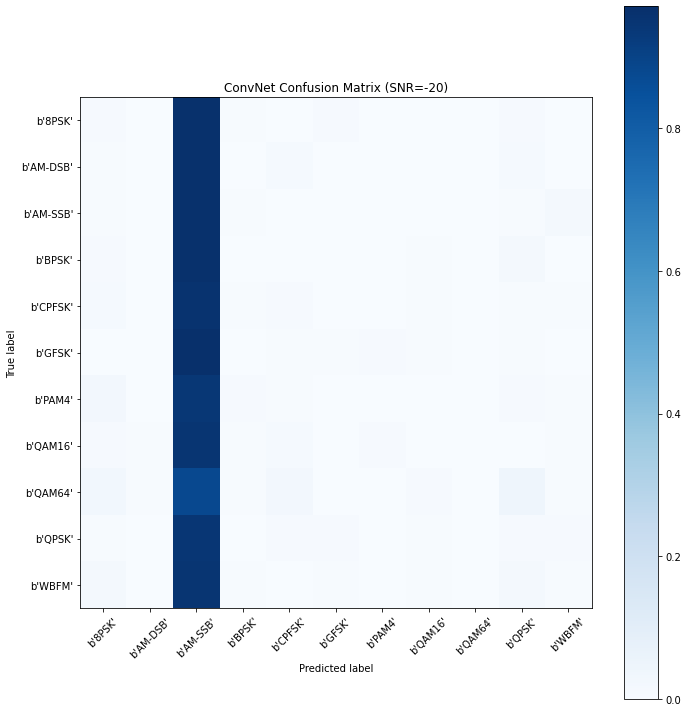

<Figure size 432x288 with 0 Axes>

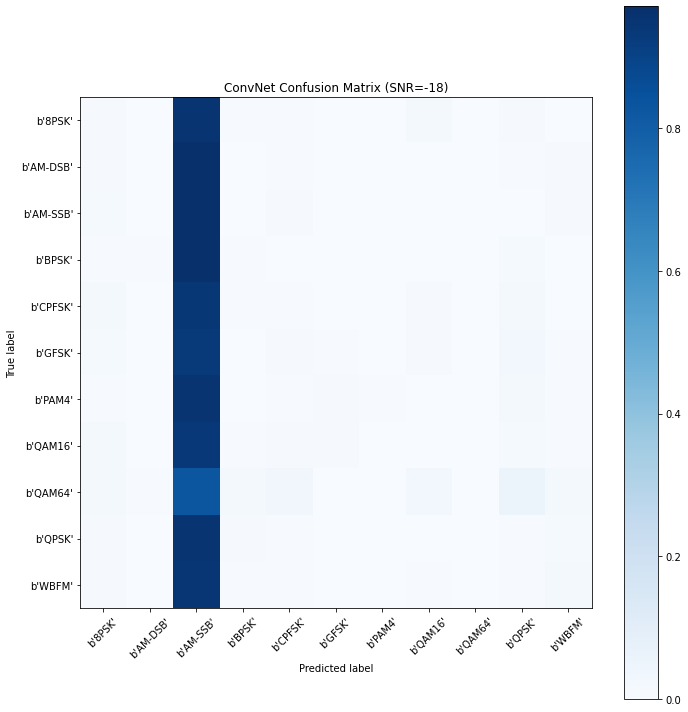

<Figure size 432x288 with 0 Axes>

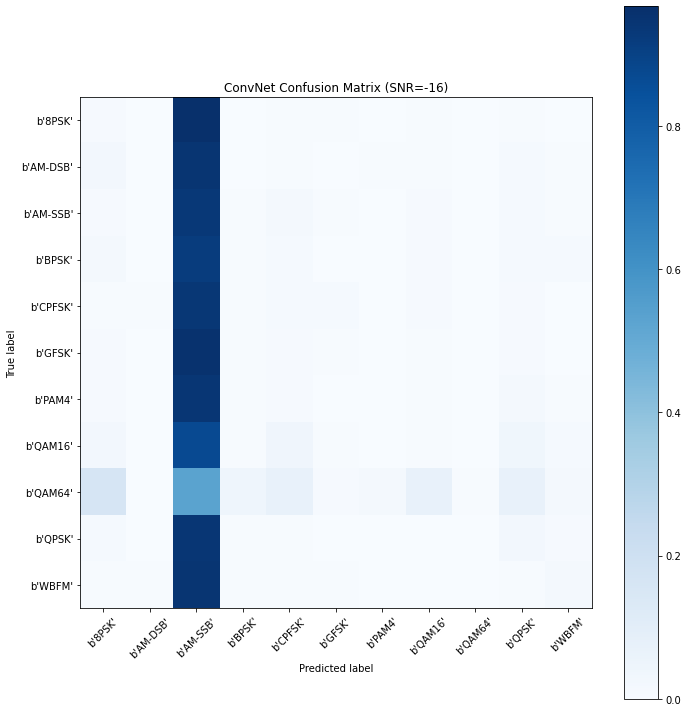

<Figure size 432x288 with 0 Axes>

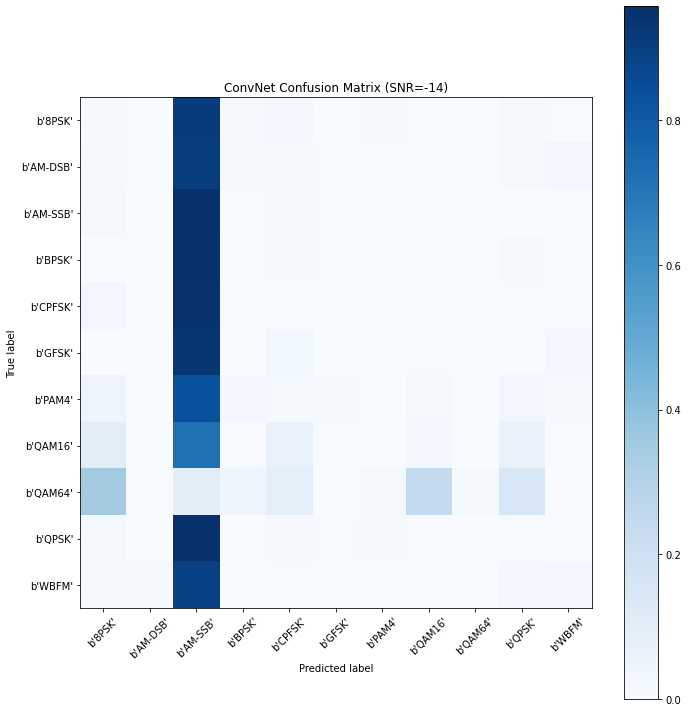

<Figure size 432x288 with 0 Axes>

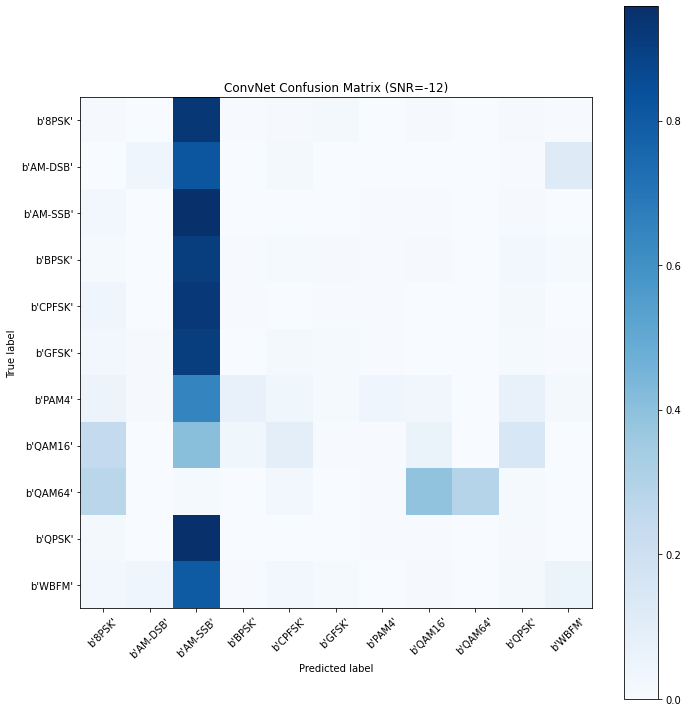

<Figure size 432x288 with 0 Axes>

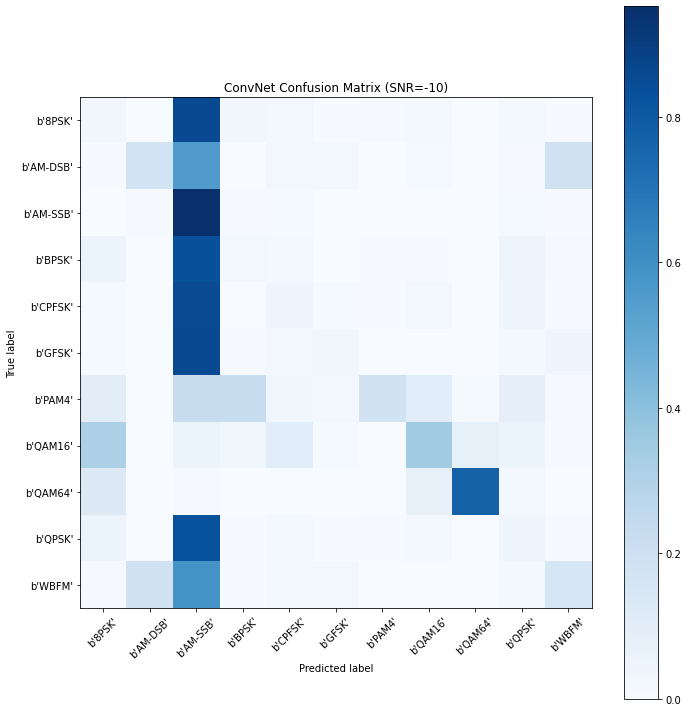

<Figure size 432x288 with 0 Axes>

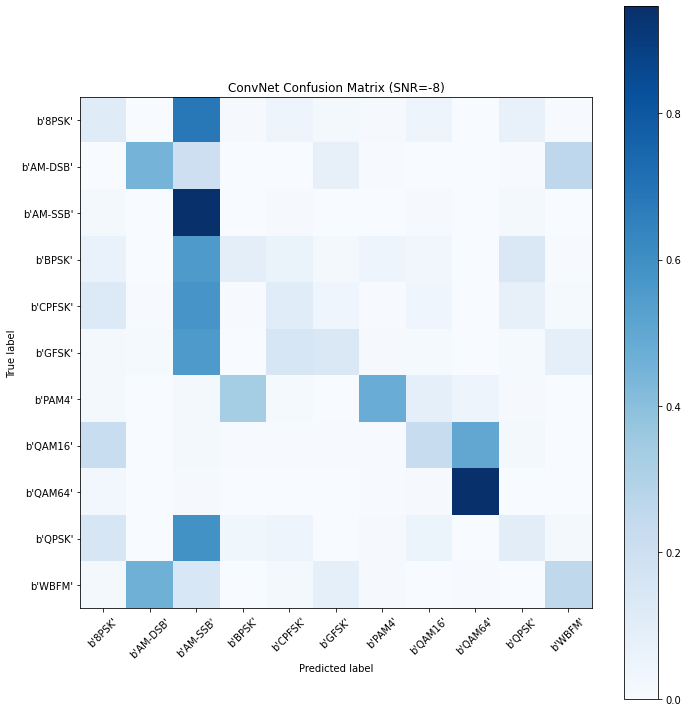

<Figure size 432x288 with 0 Axes>

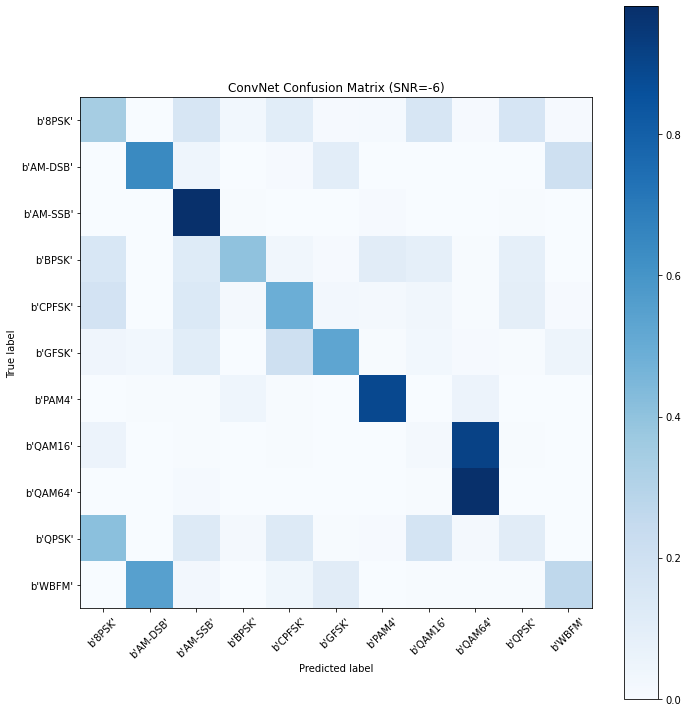

<Figure size 432x288 with 0 Axes>

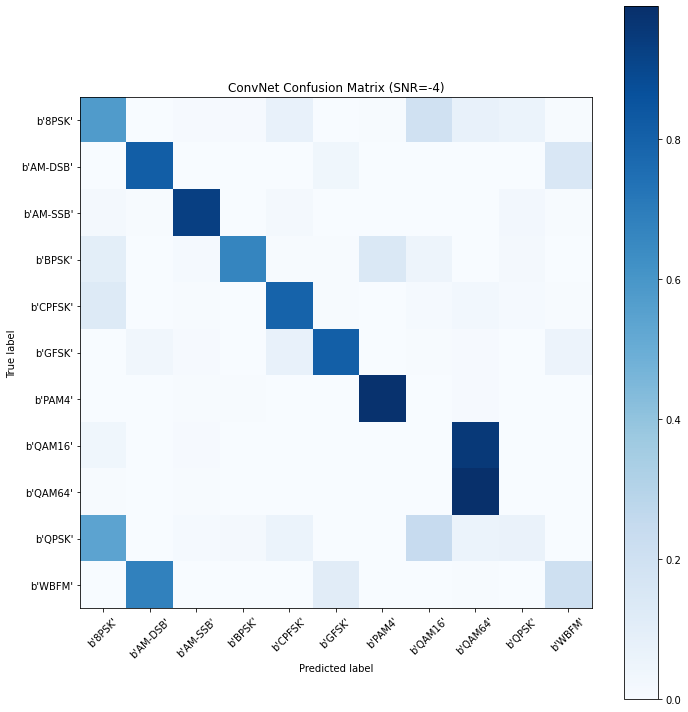

<Figure size 432x288 with 0 Axes>

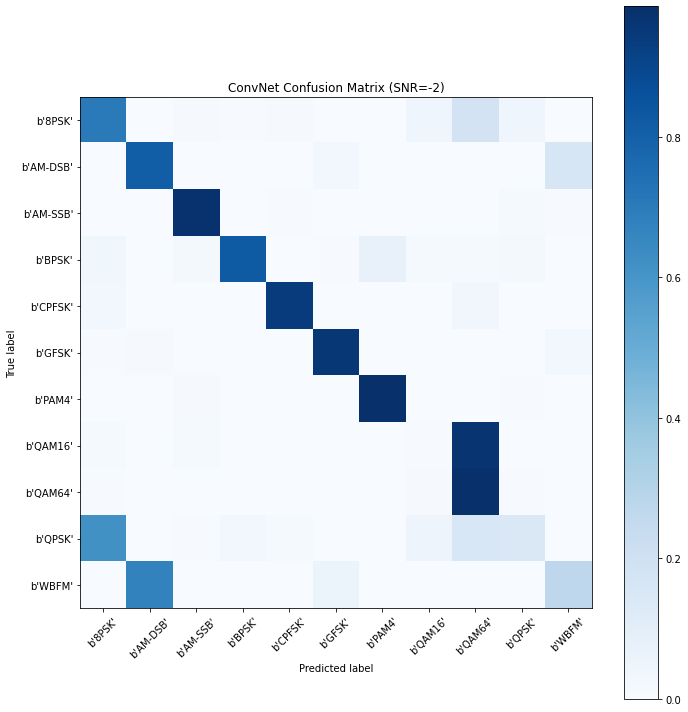

<Figure size 432x288 with 0 Axes>

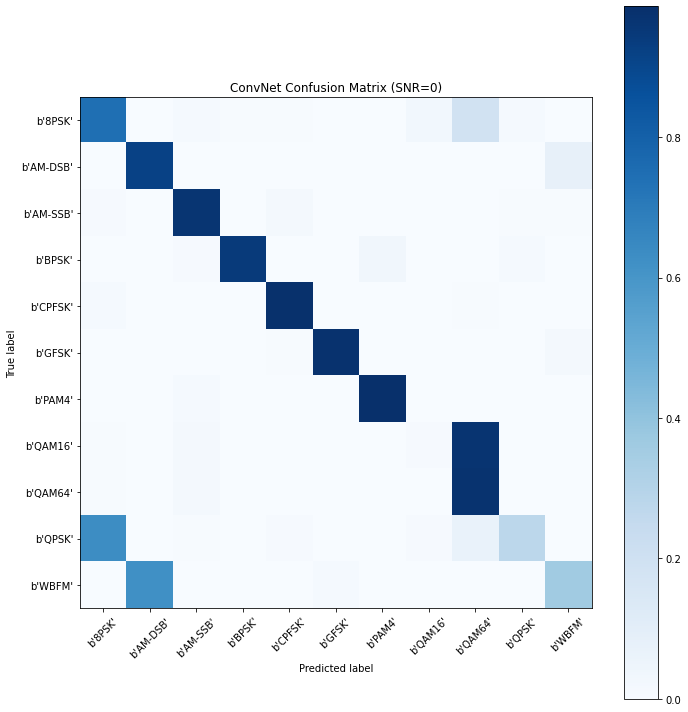

<Figure size 432x288 with 0 Axes>

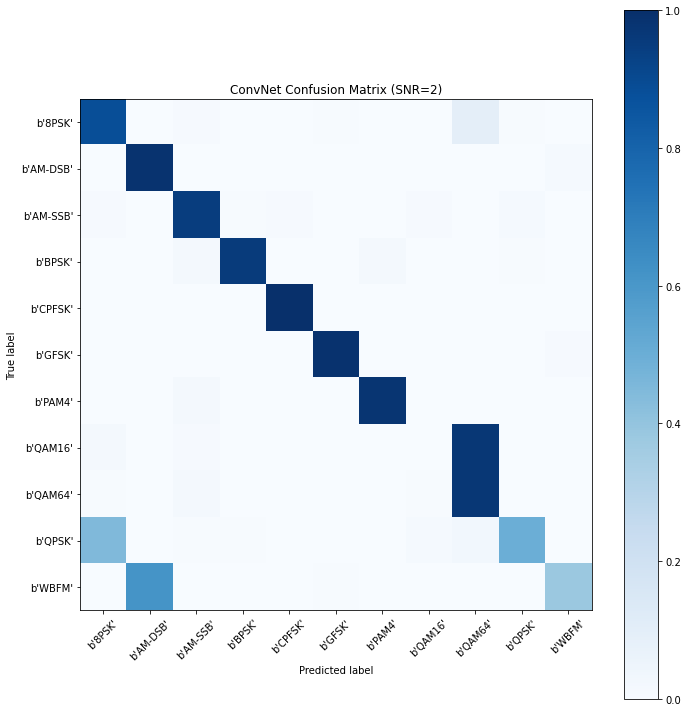

<Figure size 432x288 with 0 Axes>

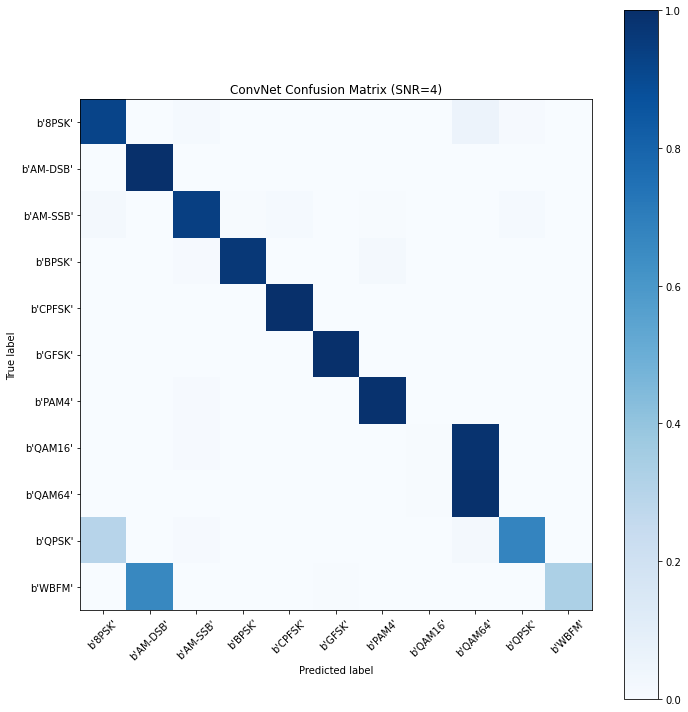

<Figure size 432x288 with 0 Axes>

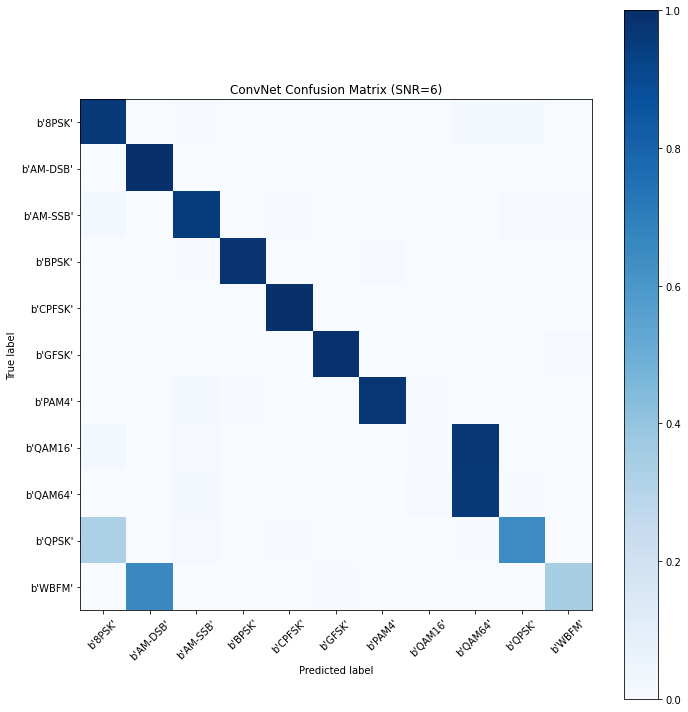

<Figure size 432x288 with 0 Axes>

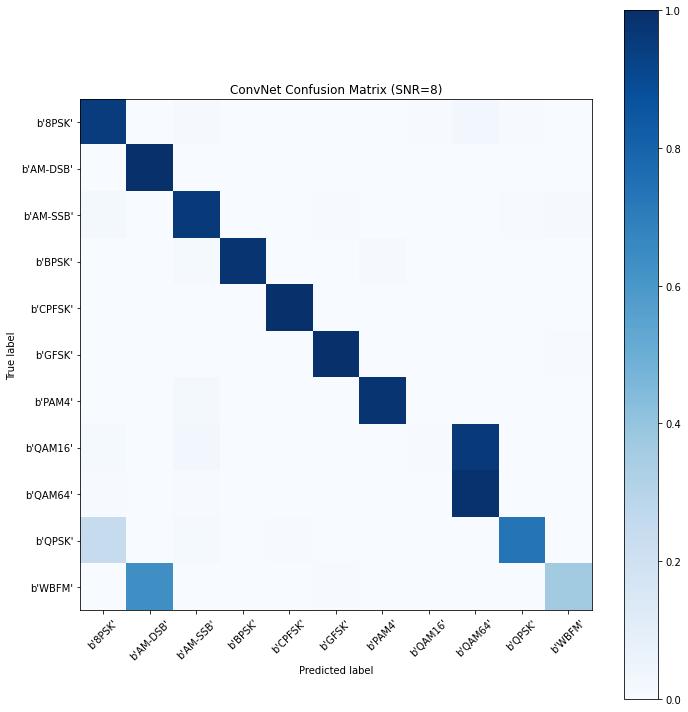

<Figure size 432x288 with 0 Axes>

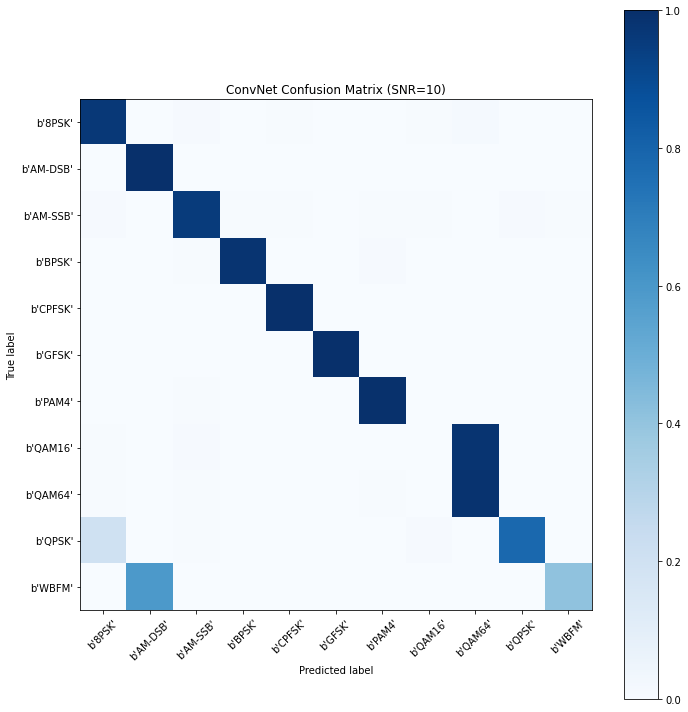

<Figure size 432x288 with 0 Axes>

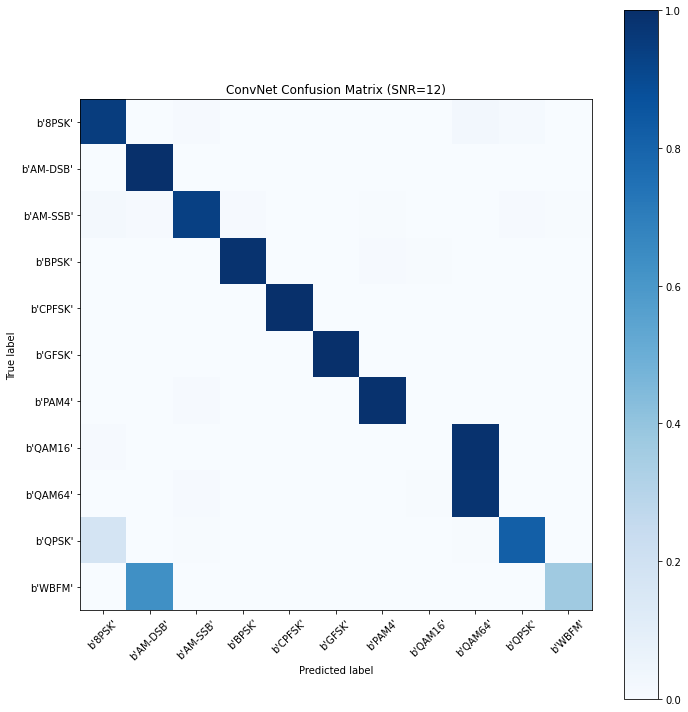

<Figure size 432x288 with 0 Axes>

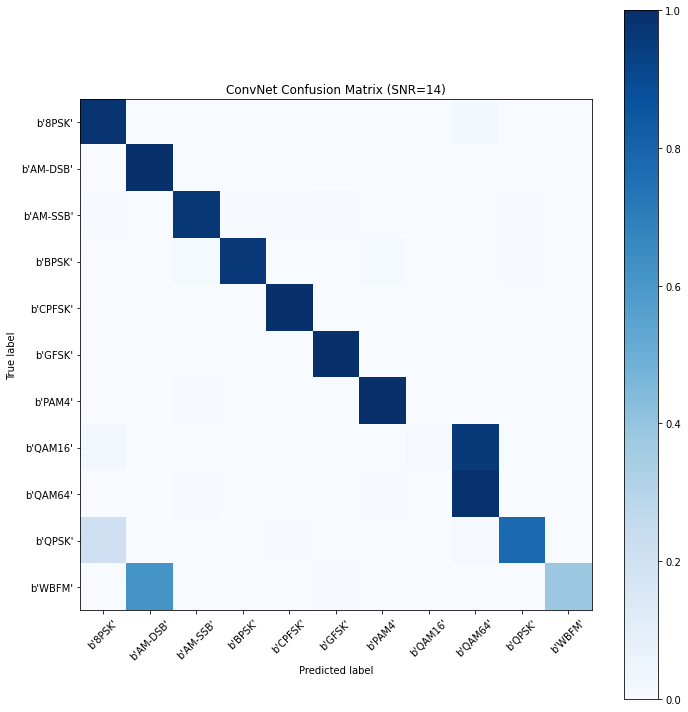

<Figure size 432x288 with 0 Axes>

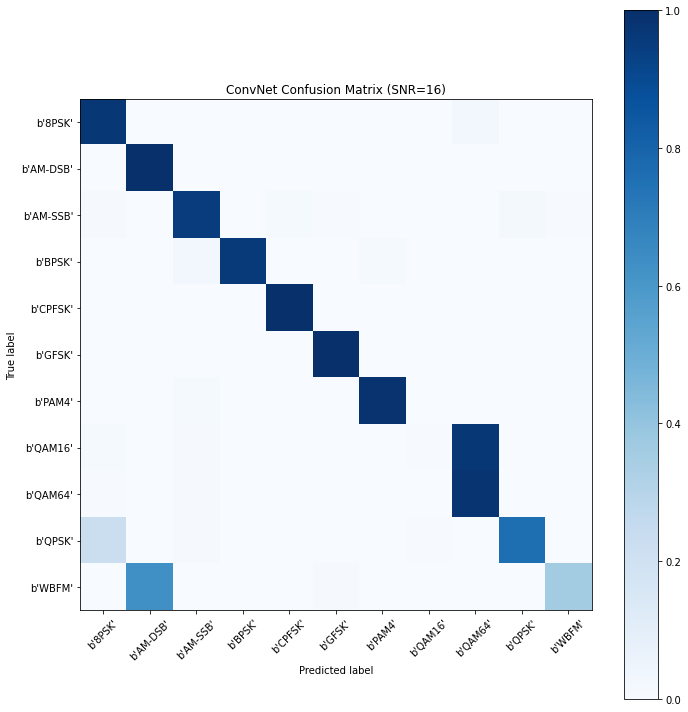

<Figure size 432x288 with 0 Axes>

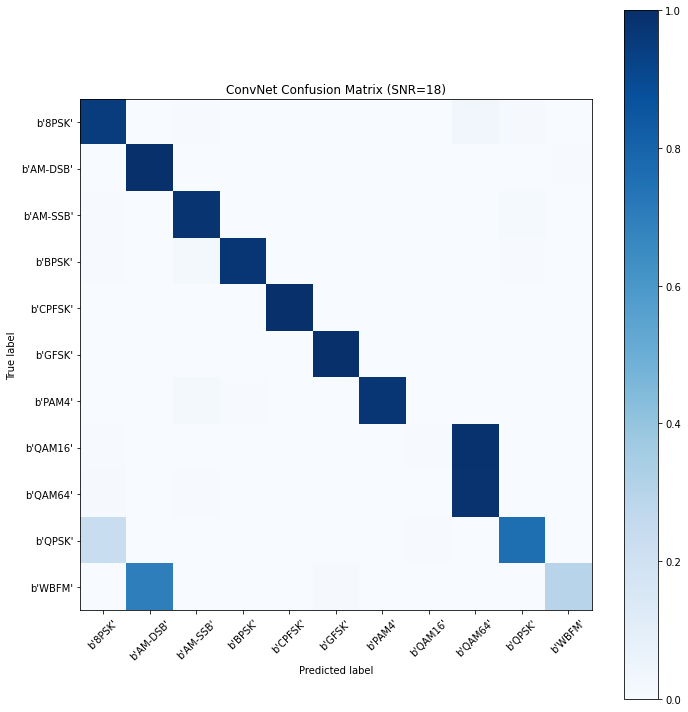

In [26]:
# Plot confusion matrix
acc = []
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test_ind[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = MRN.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc.append(1.0*cor/(cor+ncor))

In [19]:
acc_oldCNN=np.array([0.09551692589204025,
0.091916439600363303,
0.10003617945007236,
0.10447491880187,
0.15004557885141295,
0.2276523902612404,
0.34870475840529119,
0.49340175953079179,
0.58946395563770793,
0.64931059506531208,
0.70419708029197081,
0.70883315158124316,
0.72283406754772395,
0.72761732851985561,
0.71758340847610458,
0.73278688524590163,
0.72388194821654894,
0.72947038198929692,
0.72506787330316746,
0.7238523852385238])

[0.08325792 0.09872611 0.09847122 0.0805492  0.13461538 0.25326136
 0.34481196 0.50849013 0.62431193 0.69033966 0.74540565 0.78384477
 0.79886686 0.78515804 0.81550802 0.83241758 0.8292797  0.83154122
 0.82188065 0.81510297]


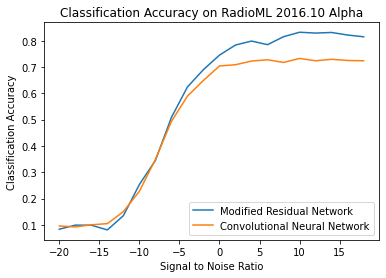

In [27]:
acc=np.array(acc)
print(np.array(acc))
plt.plot(snrs, acc)
plt.plot(snrs, acc_oldCNN)
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on RadioML 2016.10 Alpha")
plt.legend(["Modified Residual Network","Convolutional Neural Network"])
plt.savefig('Classification Accuracy MRN.png')
# files.download('Classification Accuracy MRN.png')